# Baseline Soybean Classification

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from PIL import ImageFilter
import random

## File Paths

In [2]:
train_dir = "TrainData/"
train_ann = "TrainAnnotations.csv"
test_dir = "TestData/"

In [3]:
def load_data():
    """
    Load the image training data and classes
    :return: list of numpy arrays, list of integer labels, list of string filenames (for reference)
    """
    file_labels = pd.read_csv(train_ann)
    ann_dict = pd.Series(file_labels.annotation.values, index=file_labels.file_name).to_dict()
    image_dict = dict.fromkeys(ann_dict.keys())
    print("Loading image data...")
    for filename in list(ann_dict.keys()):
        image_dict[filename] = np.array(Image.open(train_dir + filename))
    print("Loading complete.")
    print("Preparing training data...")
    data = []
    labels = []
    names = []
    for filename in list(ann_dict):
        data.append(image_dict[filename])
        labels.append(ann_dict[filename])
        names.append(filename)
    print("Preparation complete.")
    return data, labels, names

X, y, filenames = load_data()


Loading image data...
Loading complete.
Preparing training data...
Preparation complete.


## Visualize the Data

In [4]:
def visualize_data(array):
    """
    Plot a given numpy array
    :param array: a numpy array (image)
    """
    if len(array.shape) == 3:  # has all 3 RGB channels
        plt.imshow(array)
    else:  # just a black and white image (one channel)
        plt.imshow(array, cmap='gray')
    plt.axis("off")
    plt.show()

## Feature Extraction Functions

In [5]:
def canny_edge_filter(array, f_type="canny"):
    """
    Detect the edges within an image using a chosen filter
    :param array: a numpy array (image)
    :param f_type: the filter type in ['canny', 'laplacian', 'sobelx', 'sobely']
    :return: a numpy array (edge image)
    """
    edges = None
    if f_type == 'canny':
        edges = cv2.Canny(array, 120, 200)
    elif f_type == 'laplacian':
        # convert to grayscale --- one channel
        # Sobel filter in both directions
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Laplacian(array, cv2.CV_64F, ksize=5))
    elif f_type == "sobelx":
        # convert to grayscale --- one channel
        # get vertical edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 1, 0, ksize=5))
    elif f_type == "sobely":
        # convert to grayscale --- one channel
        # get horizontal edges
        array = np.array(Image.fromarray(array).convert('L'))
        edges = np.abs(cv2.Sobel(array, cv2.CV_64F, 0, 1, ksize=5))
    return edges

def extract_channel(array, channel='green'):
    """
    Extract one channel from the image (default green because that is arguably the most important
    for this application)
    :param array: a numpy array (image)
    :param channel: string in ('red', 'green', 'blue')
    :return: a numpy array (image, one channel)
    """
    channel_dict = {'red': 0, 'green': 1, 'blue': 2}
    matrix = array[:, :, channel_dict[channel]]
    return matrix

def extract_pillow_edges(array, grayscale=False, visualize=False):
    """
    Get the result of pillow find_edges filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the find_edge image or not [True, False]
    :return: find_edge vector (for training), find_edge image (for visualization)
    """
    image = Image.fromarray(array)      
    find_edge_image = image.filter(ImageFilter.FIND_EDGES)        
    if grayscale:
        find_edge_image = find_edge_image.convert("L")      
    find_edge_image_array = np.array(find_edge_image)
    if visualize:
        find_edge_image.show()         
    return find_edge_image_array
    
def extract_pillow_contour(array, grayscale=False, visualize=False):
    """
    Get the result of pillow contour filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the contour image or not [True, False]
    :return: contour vector (for training), contour image (for visualization)
    """
    image = Image.fromarray(array)
    contour_image = image.filter(ImageFilter.CONTOUR)
    if grayscale:
        coutour_image = contour_image.convert("L")
    contour_image_array = np.array(contour_image)
    if visualize:
        contour_image.show()  
    return contour_image_array

def extract_pillow_emboss(array, grayscale=False, visualize=False):
    """
    Get the result of pillow emboss filter
    :param array:  a numpy array (image)
    :param visualize: to visualize the emboss image or not [True, False]
    :return: emboss vector (for training), emboss image (for visualization)
    """
    image = Image.fromarray(array)
    emboss_image = image.filter(ImageFilter.EMBOSS)        
    if grayscale:
        emboss_image = emboss_image.convert("L")    
    emboss_image_array = np.array(emboss_image)
    if visualize:
        emboss_image.show()          
    return emboss_image_array

def extract_hog(array, visualize=False):
    """
    Get the Histogram of Gradients of the image
    :param array: a numpy array (image)
    :param visualize: to visualize the HOG image or not [True, False]
    :return: HOG vector (for training), HOG image (for visualization)
    """
    if visualize:
        vector, im = hog(array,
                         orientations=8,
                         pixels_per_cell=(4, 4),
                         cells_per_block=(1, 1),
                         block_norm='L2-Hys',
                         feature_vector=True,
                         visualize=True)
        return vector, im
    else:
        vector = hog(array,
                     orientations=8,
                     pixels_per_cell=(4, 4),
                     cells_per_block=(1, 1),
                     feature_vector=True,
                     block_norm='L2-Hys')
        return vector

## Features

In [6]:
print("Extracting features...")
# lists of non-flattened numpy arrays
rgb = []
grayscale = []
hogs = []
greens = []
canny_edges = []
edges = []
embosses = []
contours = []
for i in range(len(X)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X))
    rgb.append(X[i])
    grayscale.append(np.array(Image.fromarray(X[i]).convert('L')))
    hogs.append(extract_hog(X[i], visualize=False))
    greens.append(extract_channel(X[i], channel="green"))
    canny_edges.append(canny_edge_filter(X[i]))
    edges.append(extract_pillow_edges(X[i]))
    embosses.append(extract_pillow_emboss(X[i]))
    contours.append(extract_pillow_contour(X[i]))
print("Feature Extraction Complete.")

Extracting features...
Preprocessing Image 1 / 1025
Preprocessing Image 11 / 1025
Preprocessing Image 21 / 1025
Preprocessing Image 31 / 1025
Preprocessing Image 41 / 1025
Preprocessing Image 51 / 1025
Preprocessing Image 61 / 1025
Preprocessing Image 71 / 1025
Preprocessing Image 81 / 1025
Preprocessing Image 91 / 1025
Preprocessing Image 101 / 1025
Preprocessing Image 111 / 1025
Preprocessing Image 121 / 1025
Preprocessing Image 131 / 1025
Preprocessing Image 141 / 1025
Preprocessing Image 151 / 1025
Preprocessing Image 161 / 1025
Preprocessing Image 171 / 1025
Preprocessing Image 181 / 1025
Preprocessing Image 191 / 1025
Preprocessing Image 201 / 1025
Preprocessing Image 211 / 1025
Preprocessing Image 221 / 1025
Preprocessing Image 231 / 1025
Preprocessing Image 241 / 1025
Preprocessing Image 251 / 1025
Preprocessing Image 261 / 1025
Preprocessing Image 271 / 1025
Preprocessing Image 281 / 1025
Preprocessing Image 291 / 1025
Preprocessing Image 301 / 1025
Preprocessing Image 311 / 1

## Preview Random Image

### Do any visualization you want here before the data is flattened in the next section

Previewing image 002115.jpg from class 2


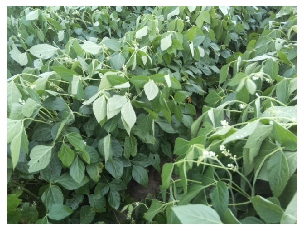

In [7]:
# RGB
index = random.randint(0, len(X))
print("Previewing image", filenames[index], "from class", y[index])
visualize_data(rgb[index])

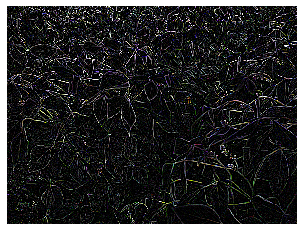

In [8]:
# Edge
visualize_data(edges[index])

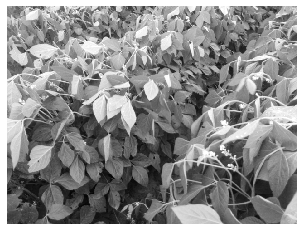

In [9]:
# Green
visualize_data(greens[index])

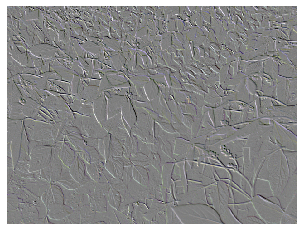

In [10]:
# Emboss
visualize_data(embosses[index])

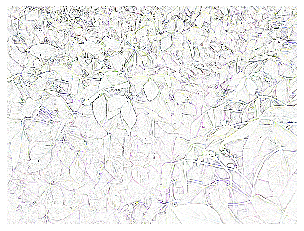

In [11]:
# Contour
visualize_data(contours[index])

## Flatten the Data

In [7]:
print("Flattening data...")
rgbs = np.array([r.flatten() for r in rgb])
grayscales = np.array([g.flatten() for g in grayscale])
hogs = np.array([h.flatten() for h in hogs])
greens = np.array([g.flatten() for g in greens])
edges = np.array([e.flatten() for e in edges])
canny_edges = np.array([e.flatten() for e in canny_edges])
contours = np.array([c.flatten() for c in contours])
embosses = np.array([e.flatten() for e in embosses])
print("Data flattening complete.")

Flattening data...
Data flattening complete.


## Train and Validate a Model on Each Individual Feature Representation

In [13]:
representation_names = ["RGB", "Grayscale", "Histogram of Oriented Gradients", "Green Channel", "Edge", "Canny Edge", "Contour", "Emboss"]
representations = [rgbs, grayscales, hogs, greens, edges, canny_edges, contours, embosses]
for i in range(len(representations)):
    representation = representations[i]
    representation_name = representation_names[i]
    X, _, _ = load_data()
    for j in range(len(X)):
        features = (np.array([]), representation[j])
        X[j] = np.concatenate(features, axis=0)
    print("Building " + representation_name + " feature representation complete.")
    
    # Split the Data
    X = np.array(X)
    y = np.array(y)
    print("Vector size:", X[0].shape)

    print("Splitting the data...")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                          train_size=0.7,
                                                          random_state=138,
                                                          shuffle=True,
                                                          stratify=y)
    print("Splitting complete.")
    
    # Train the Model
    print("Training the " + representation_name + " model...")
    clf = svm.SVC(kernel="rbf", random_state=42)
    clf.fit(X_train, y_train)
    print("Training complete.")
    # Training Accuracy
    y_hat = clf.predict(X_train)
    accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
    print("Training Accuracy on " + representation_name + " data:", accuracy)
    
    # Validate the Model
    # Predict on Validation Set (validation accuracy)
    print("Validating the " + representation_name + " model...")
    y_hat = clf.predict(X_valid)
    accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
    print("Validation Accuracy on " + representation_name + " data:", accuracy)
    print()

Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building RGB feature representation complete.
Vector size: (921600,)
Splitting the data...
Splitting complete.
Training the RGB model...
Training complete.
Training Accuracy on RGB data: 0.9693165969316597
Validating the RGB model...
Validation Accuracy on RGB data: 0.7662337662337663

Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building Grayscale feature representation complete.
Vector size: (307200,)
Splitting the data...
Splitting complete.
Training the Grayscale model...
Training complete.
Training Accuracy on Grayscale data: 0.9748953974895398
Validating the Grayscale model...
Validation Accuracy on Grayscale data: 0.7564935064935064

Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building Histogram of Oriented Gradients feature representation complete.
Vector size: (153600,)
Splitting the data...
Splitting 

## Edges and Contours
#### The features with which you'd like to represent each image

In [9]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, _, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), edges[i], contours[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

# Split the Data
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

# Train the Model
print("Training the " + "Edges + Contours" + " model...")
clf = svm.SVC(kernel="rbf", random_state=42)
clf.fit(X_train, y_train)
print("Training complete.")
# Training Accuracy
y_hat = clf.predict(X_train)
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print("Training Accuracy on " + "Edges + Contours" + " data:", accuracy)

# Validate the Model
# Predict on Validation Set (validation accuracy)
print("Validating the " + "Edges + Contours" + " model...")
y_hat = clf.predict(X_valid)
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print("Validation Accuracy on " + "Edges + Contours" + " data:", accuracy)
print()

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (1843200,)
Splitting the data...
Splitting complete.
Training the Edges + Contours model...
Training complete.
Training Accuracy on Edges + Contours data: 0.5718270571827058
Validating the Edges + Contours model...
Validation Accuracy on Edges + Contours data: 0.5454545454545454



## Green + Edge
#### The features with which you'd like to represent each image

In [10]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, _, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), greens[i], edges[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

# Split the Data
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

# Train the Model
print("Training the " + "Green + Contours" + " model...")
clf = svm.SVC(kernel="rbf", random_state=42)
clf.fit(X_train, y_train)
print("Training complete.")
# Training Accuracy
y_hat = clf.predict(X_train)
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print("Training Accuracy on " + "Green + Contours" + " data:", accuracy)

# Validate the Model
# Predict on Validation Set (validation accuracy)
print("Validating the " + "Green + Contours" + " model...")
y_hat = clf.predict(X_valid)
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print("Validation Accuracy on " + "Green + Contours" + " data:", accuracy)
print()

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (1228800,)
Splitting the data...
Splitting complete.
Training the Green + Contours model...
Training complete.
Training Accuracy on Green + Contours data: 0.8744769874476988
Validating the Green + Contours model...
Validation Accuracy on Green + Contours data: 0.6006493506493507



## HOG + Green
### The features with which you'd like to represent the image

In [11]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, y, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), hogs[i], greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

# Split the Data
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

# Train the Model
print("Training the " + "HOGs + Greens" + " model...")
clf = svm.SVC(kernel="rbf", random_state=42)
clf.fit(X_train, y_train)
print("Training complete.")
# Training Accuracy
y_hat = clf.predict(X_train)
accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
print("Training Accuracy on " + "HOGs + Greens" + " data:", accuracy)

# Validate the Model
# Predict on Validation Set (validation accuracy)
print("Validating the " + "HOGs + Greens" + " model...")
y_hat = clf.predict(X_valid)
accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
print("Validation Accuracy on " + "HOGs + Greens" + " data:", accuracy)
print()

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Splitting the data...
Splitting complete.
Training the HOGs + Greens model...
Training complete.
Training Accuracy on HOGs + Greens data: 0.806136680613668
Validating the HOGs + Greens model...
Validation Accuracy on HOGs + Greens data: 0.711038961038961



## Hyperparameter optimization
Using `scikit-optimize`, the hyperparameters of the model can be optimized to maximize validation accuracy.

In [69]:
from skopt.optimizer import gp_minimize
from skopt.space.space import Categorical, Integer, Real
from skopt.utils import use_named_args

kernel_dim = Categorical(['linear', 'poly', 'rbf'], name='kernel')
degree_dim = Integer(low=2, high=5, name='degree') # only for 'poly' kernel
gamma_dim = Categorical(['scale', 'auto', .0001, 0.001, 0.01], name='gamma')
C_dim = Categorical([0, 0.1, 1, 10, 100], name='C')

shrinking_dim = Categorical([True, False], name='shrinking')
probability_dim = Categorical([True, False], name='probability')
tol_dim = Real(low=1e-4, high=1e-2, prior='log_uniform', name='tol')
random_state = 42

dimensions = [ kernel_dim, degree_dim, gamma_dim, C_dim ]

@use_named_args(dimensions=dimensions)
def fitness(kernel, degree, gamma, C):
    return 1 / fit_svm(kernel, degree, gamma, C)

def fit_svm(kernel, degree, gamma, C):
    print("Building training data...")
    X, y, _ = load_data()
    for i in range(len(X)):
        features = (np.array([]), hogs[i], greens[i])
        X[i] = np.concatenate(features, axis=0)
    print("Building feature representation complete.")

    # Split the Data
    X = np.array(X)
    y = np.array(y)
    print("Vector size:", X[0].shape)

    print("Splitting the data...")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                          train_size=0.7,
                                                          random_state=138,
                                                          shuffle=True,
                                                          stratify=y)
    print("Splitting complete.")
    print("Fitting with parameters kernel={}, degree={}, gamma={}, C={}".format(kernel, degree, gamma, C))
    clf = svm.SVC(kernel=kernel, 
                  degree=degree,
                  gamma=gamma,
                  C=C,
                  random_state=42)
    clf.fit(X_train, y_train)
    
    y_hat = clf.predict(X_train)
    train_accuracy = np.sum(y_train == y_hat) / y_train.shape[0]
    print("Training Accuracy:", train_accuracy)
    
    # Predict on Validation Set (validation accuracy)
    print("Validating the model...")
    y_hat = clf.predict(X_valid)
    validation_accuracy = np.sum(y_valid == y_hat) / y_valid.shape[0]
    print("Validation Accuracy:", validation_accuracy)
    return validation_accuracy


default_parameters = ['rbf', 3, 'scale', 1]

print('Starting optimization...')
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters,
                            random_state=random_state)

print(search_result.x)
print(search_result.fun)
print(1 / search_result.fun)

optimal_kernel = search_result.x[0]
optimal_degree = search_result.x[1]
optimal_gamma = search_result.x[2]
optimal_C = search_result.x[3]

print("Best hyperparameters found: ")
print("    kernel=", optimal_kernel)
print("    degree=", optimal_degree)
print("    gamma=", optimal_gamma)
print("    C=", optimal_C)

Starting optimization...
Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Splitting the data...
Splitting complete.
Fitting with parameters kernel=rbf, degree=3, gamma=scale, C=1
Training Accuracy: 0.806136680613668
Validating the model...
Validation Accuracy: 0.711038961038961
Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Splitting the data...
Splitting complete.
Fitting with parameters kernel=rbf, degree=3, gamma=0.001, C=1
Training Accuracy: 1.0
Validating the model...
Validation Accuracy: 0.4772727272727273
Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Splitting the data...
Splitting comple

## HOG and Green with tuned hyperparameters

In [8]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, y, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), hogs[i], greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

# Split the Data
X = np.array(X)
y = np.array(y)
print("Vector size:", X[0].shape)

print("Splitting the data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.7,
                                                      random_state=138,
                                                      shuffle=True,
                                                      stratify=y)
print("Splitting complete.")

# Train the Model
print("Training the " + "HOGs + Greens (Tuned)" + " model...")
clf = svm.SVC(kernel='poly', degree=2, gamma=0.0001, C=0.1, random_state=42)
clf.fit(X_train, y_train)
print("Training complete.")
# Training Accuracy
y_hat_train = clf.predict(X_train)
accuracy = np.sum(y_train == y_hat_train) / y_train.shape[0]
print("Training Accuracy on " + "HOGs + Greens" + " data:", accuracy)

# Validate the Model
# Predict on Validation Set (validation accuracy)
print("Validating the " + "HOGs + Greens (Tuned)" + " model...")
y_hat_valid = clf.predict(X_valid)
accuracy = np.sum(y_valid == y_hat_valid) / y_valid.shape[0]
print("Validation Accuracy on " + "HOGs + Greens" + " data:", accuracy)
print()

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Splitting the data...
Splitting complete.
Training the HOGs + Greens (Tuned) model...
Training complete.
Training Accuracy on HOGs + Greens data: 1.0
Validating the HOGs + Greens (Tuned) model...
Validation Accuracy on HOGs + Greens data: 0.8441558441558441



## Plots

In [10]:
confusion_matrix = np.zeros((5, 5))
labels = [0, 1, 2, 3, 4]
for i in range(len(labels)):
    for j in range(len(labels)):
        ground_truth = y_valid==labels[i]
        prediction = y_hat_valid==labels[j]
        confusion_matrix[i, j] = sum(np.bitwise_and(ground_truth, prediction))
pd.DataFrame(confusion_matrix, dtype=int)

,0,1,2,3,4
0,128,13,4,2,0
1,14,42,0,0,0
2,3,4,29,3,0
3,0,0,3,36,0
4,0,0,0,2,25


In [11]:
from sklearn.decomposition import PCA

print("Fitting PCA to Training Data...")
pca_train = PCA(n_components=2)
x_train = pca_train.fit_transform(X_train)
print("Fitting complete.")

print("Fitting PCA to Validation Data...")
pca_valid = PCA(n_components=2)
x_valid = pca_valid.fit_transform(X_valid)
print("Fitting complete.")

Fitting PCA to Training Data...
Fitting complete.
Fitting PCA to Validation Data...
Fitting complete.


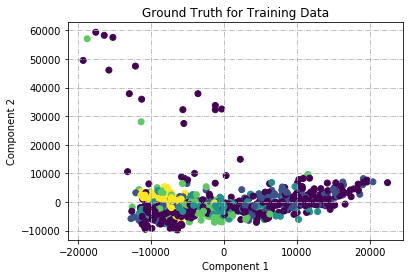

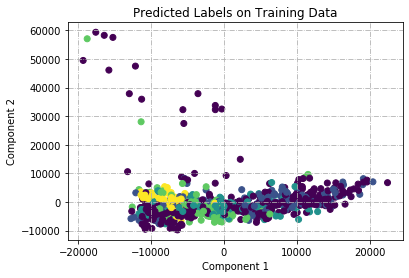

In [12]:
xs = [x[0] for x in x_train]
ys = [x[1] for x in x_train]
plt.title("Ground Truth for Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.scatter(xs, ys, c=y_train)
plt.grid(True, linestyle='-.')
plt.show()

plt.title("Predicted Labels on Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.scatter(xs, ys, c=y_hat_train)
plt.grid(True, linestyle='-.')
plt.show()

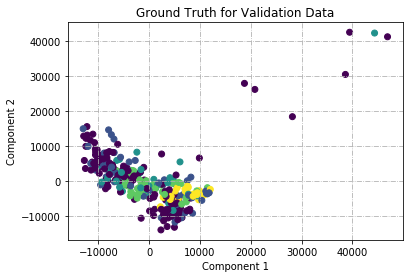

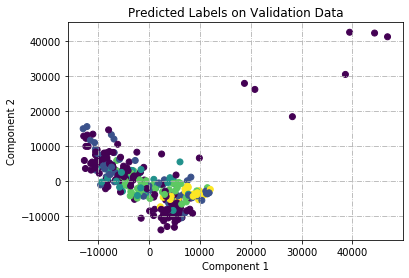

In [13]:
xs = [x[0] for x in x_valid]
ys = [x[1] for x in x_valid]
plt.title("Ground Truth for Validation Data")
plt.scatter(xs, ys, c=y_valid)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='-.')
plt.show()

plt.title("Predicted Labels on Validation Data")
plt.scatter(xs, ys, c=y_hat_valid)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='-.')
plt.show()

## Test the Model

Loading image data...
Loading complete.
Visualizing TestData/20018.jpg


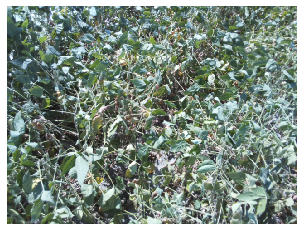

In [14]:
import os

def load_test_data():
    """
    Load the image test data and classes
    :return: list of numpy arrays, list of filenames
    """
    print("Loading image data...")
    test_image_list = []
    filenames = sorted(os.listdir(test_dir))
    for filename in filenames:
        test_image_list.append(np.array(Image.open(test_dir + filename)))
    print("Loading complete.")
    return test_image_list, filenames

X, filenames = load_test_data()
print("Visualizing " + test_dir + filenames[0])
visualize_data(X[0])

In [15]:
# can be any number of features, just leave np.array([]). This allows for one feature to be used alone
# e.g. features = (np.array([]), hogs[i]); features = (np.array([]), hogs[i], greens[i])
print("Building training data...")
X, y, _ = load_data()
for i in range(len(X)):
    features = (np.array([]), hogs[i], greens[i])
    X[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

# DON'T Split the Data
X_train = np.array(X)
y_train = np.array(y)
print("Vector size:", X_train[0].shape)

# Train the Model
print("Training the " + "HOGs + Greens (Tuned)" + " model...")
clf = svm.SVC(kernel='poly', degree=2, gamma=0.0001, C=0.1, random_state=42)
clf.fit(X_train, y_train)
print("Training complete.")
# Training Accuracy
y_hat_train = clf.predict(X_train)
accuracy = np.sum(y_train == y_hat_train) / y_train.shape[0]
print("Training Accuracy on " + "HOGs + Greens" + " data:", accuracy)

Building training data...
Loading image data...
Loading complete.
Preparing training data...
Preparation complete.
Building feature representation complete.
Vector size: (460800,)
Training the HOGs + Greens (Tuned) model...
Training complete.
Training Accuracy on HOGs + Greens data: 1.0


In [16]:
X_test, _ = load_test_data()
hogs_test = []
greens_test = []
print("Extracting features...")
for i in range(len(X_test)):
    if i % 10 == 0:
        print("Preprocessing Image", i+1, '/', len(X_test))
    hogs_test.append(extract_hog(X_test[i], visualize=False))
    greens_test.append(extract_channel(X_test[i], channel="green"))
print("Feature Extraction Complete.")

Loading image data...
Loading complete.
Extracting features...
Preprocessing Image 1 / 300
Preprocessing Image 11 / 300
Preprocessing Image 21 / 300
Preprocessing Image 31 / 300
Preprocessing Image 41 / 300
Preprocessing Image 51 / 300
Preprocessing Image 61 / 300
Preprocessing Image 71 / 300
Preprocessing Image 81 / 300
Preprocessing Image 91 / 300
Preprocessing Image 101 / 300
Preprocessing Image 111 / 300
Preprocessing Image 121 / 300
Preprocessing Image 131 / 300
Preprocessing Image 141 / 300
Preprocessing Image 151 / 300
Preprocessing Image 161 / 300
Preprocessing Image 171 / 300
Preprocessing Image 181 / 300
Preprocessing Image 191 / 300
Preprocessing Image 201 / 300
Preprocessing Image 211 / 300
Preprocessing Image 221 / 300
Preprocessing Image 231 / 300
Preprocessing Image 241 / 300
Preprocessing Image 251 / 300
Preprocessing Image 261 / 300
Preprocessing Image 271 / 300
Preprocessing Image 281 / 300
Preprocessing Image 291 / 300
Feature Extraction Complete.


In [17]:
print("Flattening data...")
hogs_test = np.array([h.flatten() for h in hogs_test])
greens_test = np.array([g.flatten() for g in greens_test])
print("Data flattening complete.")
print("Building test data...")
for i in range(len(X_test)):
    features = (np.array([]), hogs_test[i], greens_test[i])
    X_test[i] = np.concatenate(features, axis=0)
print("Building feature representation complete.")

Flattening data...
Data flattening complete.
Building test data...
Building feature representation complete.


In [18]:
import csv
print("Testing the model...")
y_hat_test = clf.predict(X_test)
print("Testing complete.")
one_hots = [np.zeros((5,1)) for pred in y_hat_test]
for i in range(len(one_hots)):
    pred = y_hat_test[i]  # the index of the one-hot encoding
    one_hots[i][pred] = 1
with open('predictions.csv', 'w') as predictions_file:
    writer = csv.writer(predictions_file, delimiter=',')
    for pred in one_hots:
        writer.writerow(pred.T) 

Testing the model...
Testing complete.
